## Initial imports

In [1]:
from scm.plams import *
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import List

## Function definitions

The ``addition()`` function 

* performs a preliminary MD simulation with UFF to arrange the two reactant molecules at an approximate transition state,

* then does a transition state search with DFTB, specifying the known reaction coordinate (bond formation),

* then uses the PESExploration LandscapeRefinement tool to get the two corresponding minima and energy landscape. Alternatively, one could also do an IRC (intrinsic reaction coordinate) calculation.

In [2]:
def addition(
    mol1: Molecule,
    mol2: Molecule,
    covalent_radius_multiplier: float = 1.2,
):
    mol1_ind = get_active_i(mol1)
    mol2_ind = get_active_i(mol2)
    if len(mol1_ind) != 2:
        raise ValueError(f"Set at.properties.active_bond for two atoms in mol1. Current mol1_ind: {mol1_ind}")
    if len(mol2_ind) != 2:
        raise ValueError(f"Set at.properties.active_bond for two atoms in mol2. Current mol2_ind: {mol2_ind}")

    target_distances = []

    for i1, i2 in zip(mol1_ind, mol2_ind):
        r = get_atom_radius(mol1[i1]) + get_atom_radius(mol2[i2])
        target_distances.append(r * covalent_radius_multiplier)

    combined = mol1.copy()
    combined.add_molecule(mol2, margin=2)
    combined.properties.charge = mol1.properties.get("charge", 0) + mol2.properties.get("charge", 0)

    mol2_ind = [x + len(mol1) for x in mol2_ind]

    preliminary_md_results = preliminary_md(
        combined,
        mol1_ind,
        mol2_ind,
        target_distances=target_distances,
        temperature=600,
        nsteps=20000,
    )
    mol = preliminary_md_results.get_main_molecule()

    ts_search_results = ts_search(mol, mol1_ind, mol2_ind)
    mol = ts_search_results.get_main_molecule()

    relax_from_saddle_results = relax_from_saddle(mol)

    return preliminary_md_results, ts_search_results, relax_from_saddle_results


def ts_search(molecule, atom_indices_1: List[int], atom_indices_2: List[int], settings: Settings = None) -> AMSResults:
    if settings is None:
        settings = Settings()
        settings.input.DFTB
        # settings.runscript.nproc = 1
        settings.input.ams.GeometryOptimization.InitialHessian.Type = "Calculate"
        settings.input.ams.Properties.NormalModes = "Yes"
        settings.input.ams.GeometryOptimization.Convergence.Quality = "Good"

    s = settings.copy()
    s.input.ams.task = "TransitionStateSearch"
    s.input.ams.TransitionStateSearch.ReactionCoordinate.Distance = [
        f"{a1} {a2} 1.0" for a1, a2 in zip(atom_indices_1, atom_indices_2)
    ]

    job = AMSJob(settings=s, name="ts_search", molecule=molecule)
    job.run()

    return job.results


def relax_from_saddle(molecule: Molecule, settings: Settings = None) -> AMSResults:
    if settings is None:
        settings = Settings()
        settings.input.DFTB
        settings.input.ams.GeometryOptimization.InitialHessian.Type = "Calculate"
        # settings.runscript.nproc = 1

    s = settings.copy()
    s.input.ams.task = "PESExploration"
    s.input.ams.PESExploration.Job = "LandscapeRefinement"
    s.input.ams.PESExploration.LandscapeRefinement.RelaxFromSaddlePoint = "T"

    m = {"state1 ts=Yes": molecule}

    job = AMSJob(settings=s, name="refinement", molecule=m)
    job.run()

    return job.results


def irc(molecule: Molecule, settings: Settings = None):
    if settings is None:
        settings = Settings()
        settings.input.DFTB
        # settings.runscript.nproc = 1

    s = settings.copy()
    s.input.ams.task = "IRC"
    s.input.ams.IRC.MinEnergyProfile = "Yes"

    job = AMSJob(settings=s, name="irc", molecule=molecule)
    job.run()

    converged = job.results.get_history_property("Converged")
    direction = job.results.get_history_property("IRCDirection")
    energies = job.results.get_history_property("Energy")
    ind = dict()
    energy = dict()
    for i, (c, d, e) in enumerate(zip(converged, direction, energies)):
        if c:
            ind[d] = i + 1
            energy[d] = e

    min1 = job.results.get_history_molecule(ind[1])
    min2 = job.results.get_history_molecule(ind[2])
    ts = job.results.get_input_molecule()

    return min1, energy[1], min2, energy[2], ts, energies[0]


def preliminary_md(
    molecule: Molecule,
    atom_indices_1: List[int],
    atom_indices_2: List[int],
    target_distances: List[float],
    nsteps: int = 10000,
    kappa: float = 100000,
    settings: Settings = None,
    temperature: float = 300,
) -> Molecule:
    if settings is None:
        settings = Settings()
        settings.input.ForceField.Type = "UFF"
        settings.runscript.nproc = 1

    plumed_input = "\n"
    for a1, a2, d in zip(atom_indices_1, atom_indices_2, target_distances):
        # current_d = molecule[a1].distance_to(molecule[a2])
        plumed_input += f"DISTANCE ATOMS={a1},{a2} LABEL=d_{a1}_{a2}\n"
        plumed_input += f"MOVINGRESTRAINT ARG=d_{a1}_{a2}"
        plumed_input += f" STEP0=1 AT0={d*0.1} KAPPA0=0"
        plumed_input += f" STEP1={1*nsteps//4} KAPPA1={kappa/1000}"
        plumed_input += f" STEP2={2*nsteps//4} KAPPA2={kappa/100}"
        plumed_input += f" STEP3={3*nsteps//4} KAPPA3={kappa/10}"
        plumed_input += f" STEP4={4*nsteps//4} KAPPA4={kappa}"
        plumed_input += f"\n"

    plumed_input += "   End"
    settings.input.ams.MolecularDynamics.Plumed.Input = plumed_input

    job = AMSNVTJob(
        name="preliminary_md",
        settings=settings,
        molecule=molecule,
        nsteps=nsteps,
        temperature=3 * [temperature] + [1],
    )
    job.run()

    return job.results


def set_active(mol: Molecule, indices: List[int]):
    for at in mol:
        if "active_bond" in at.properties:
            del at.properties["active_bond"]
    for i, ind in enumerate(indices, 1):
        mol[ind].properties.active_bond = i


def get_active_i(mol: Molecule) -> List[int]:
    d = {}
    for i, at in enumerate(mol, 1):
        if "active_bond" in at.properties and at.properties.active_bond:
            d[i] = at.properties.active_bond

    return sorted(d, key=lambda x: d[x])


def get_atom_radius(at: Atom) -> float:
    return PeriodicTable.get_radius(at.symbol)

## Run the calculations

In [3]:
diene_smiles = "C1C=CC=C1"
diene = from_smiles(
    diene_smiles
)  # carbon 2, 4 will form bonds. Do diene.write('diene.xyz') and open diene.xyz in the AMS GUI to find out which atom indices are correct.
set_active(diene, [2, 4])

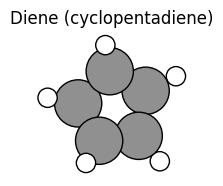

In [4]:
plot_molecule(diene)
plt.title("Diene (cyclopentadiene)");

In [5]:
dienophile = from_smiles("N#CC=C")  # carbon 1, 2 will form bonds
set_active(dienophile, [1, 2])

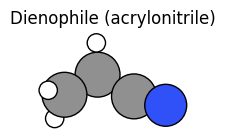

In [6]:
plot_molecule(dienophile)
plt.title("Dienophile (acrylonitrile)");

In [7]:
preliminary_md_results, ts_search_results, relax_from_saddle_results = addition(diene, dienophile)

[13.08|16:41:38] JOB preliminary_md STARTED
[13.08|16:41:38] JOB preliminary_md RUNNING
[13.08|16:41:42] JOB preliminary_md FINISHED
[13.08|16:41:43] JOB preliminary_md SUCCESSFUL
[13.08|16:41:43] JOB ts_search STARTED
[13.08|16:41:43] JOB ts_search RUNNING
[13.08|16:41:45] JOB ts_search FINISHED
[13.08|16:41:46] JOB ts_search SUCCESSFUL
[13.08|16:41:46] JOB refinement STARTED
[13.08|16:41:46] JOB refinement RUNNING
[13.08|16:41:51] JOB refinement FINISHED
[13.08|16:41:51] JOB refinement SUCCESSFUL


## Preliminary biased MD results (UFF)

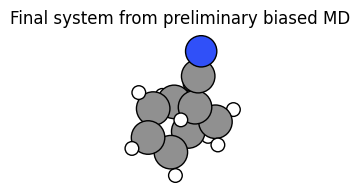

In [8]:
final_md_system = preliminary_md_results.get_main_molecule()
plot_molecule(final_md_system)
plt.title("Final system from preliminary biased MD");

## TS search results (DFTB)

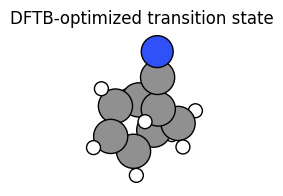

In [9]:
final_ts_system = ts_search_results.get_main_molecule()
plot_molecule(final_ts_system)
plt.title("DFTB-optimized transition state");

## Energy landscape refinement results (DFTB)

In [10]:
landscape = relax_from_saddle_results.get_energy_landscape()
print(landscape)

All stationary points:
State 1: C8H9N local minimum @ -24.90404973 Hartree (found 1 times, results on Refined1_MIN)
State 2: C8H9N local minimum @ -24.83552604 Hartree (found 1 times, results on Refined2_MIN)
State 3: C8H9N transition state @ -24.82079293 Hartree (found 1 times, results on Refined3_TS_1-2)
  +- Reactants: State 1: C8H9N local minimum @ -24.90404973 Hartree (found 1 times, results on Refined1_MIN)
     Products:  State 2: C8H9N local minimum @ -24.83552604 Hartree (found 1 times, results on Refined2_MIN)
     Prefactors: 0.000E+00:0.000E+00 s^-1
     Barriers: 2.266:0.401 eV


Above we see that the forward and backward barriers are 2.27 and 0.39 eV, respectively.

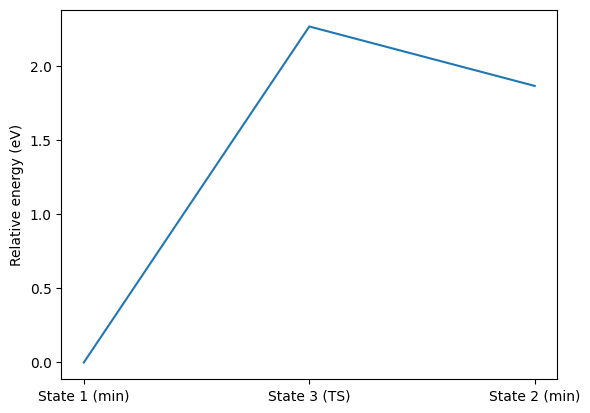

In [11]:
Ha2eV = Units.convert(1.0, "hartree", "eV")
energies = landscape[1].energy, landscape[3].energy, landscape[2].energy
energies = (np.array(energies) - landscape[1].energy) * Ha2eV
plt.plot(energies)
plt.ylabel("Relative energy (eV)")
plt.xticks([0, 1, 2], ["State 1 (min)", "State 3 (TS)", "State 2 (min)"]);

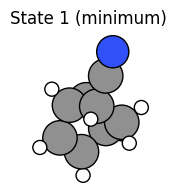

In [12]:
plot_molecule(landscape[1].molecule)
plt.title("State 1 (minimum)");

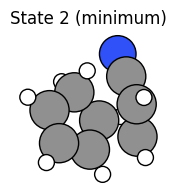

In [13]:
plot_molecule(landscape[2].molecule)
plt.title("State 2 (minimum)");

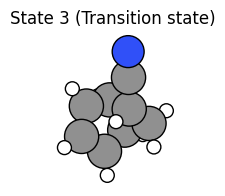

In [14]:
plot_molecule(landscape[3].molecule)
plt.title("State 3 (Transition state)");